# Análisis de Componentes Independientes ICA

## 1. Problema Directo. Mezcla de fuentes de sonido

$${\bf s = A x^T}$$
$${\bf s,x}\in R^n\times R^m, {\bf A} \in R^{n\times n}$$

**Ejemplo**
Tres diferentes fuentes de sonido independientes:
 - [Rain and Thunder](https://www.freesoundeffects.com/free-track/rain-thunder-468881/)
 - [Heartbeat 3](https://www.freesoundeffects.com/free-track/heartbeat-3-428491/)
 - [forest](https://www.freesoundeffects.com/free-track/forest-89315/)
 
Estos sonidos independientes se mezclaron con la matriz de mezcla $A$.

### 1.1. Caracterizar los archivos de sonido

In [3]:
#"""Importar bibliotecas"""
import os

import numpy             as np
import scipy             as sp
import matplotlib.pyplot as plt
import sounddevice       as sd

from scipy.io import wavfile as wav


In [4]:
#"""Configurar paths y variables"""
mainpath  = os.getcwd()+'/'
reldpath  = os.path.relpath(mainpath,'../../')
datapath  =  mainpath.split(reldpath)[0]+'data/'

L         = 154432
Fs,Sounds = [], []

In [5]:
#"""Leer archivo wav"""
fs,sound  = wav.read( datapath+'rain.wav' )

In [4]:
#"""Almacenar en un arreglo"""
Fs.append( fs ); Sounds.append( sound[:L] )

In [5]:
#"""Leer y almacenar archivos restantes"""
fs,sound  = wav.read( datapath+'forest.wav' )
Fs.append( fs ); Sounds.append( sound[:L,0] ) #es stereo

fs,sound  = wav.read( datapath+'heartbeat.wav' )
Fs.append( fs ); Sounds.append( sound[:L] )

#"""Convertir a arreglo"""
Fs = np.array(Fs); Sounds = np.array( Sounds )

In [9]:
#"""Reproducir sonidos"""
for s in Sounds:
    sd.play(s,Fs[0],blocking=True)


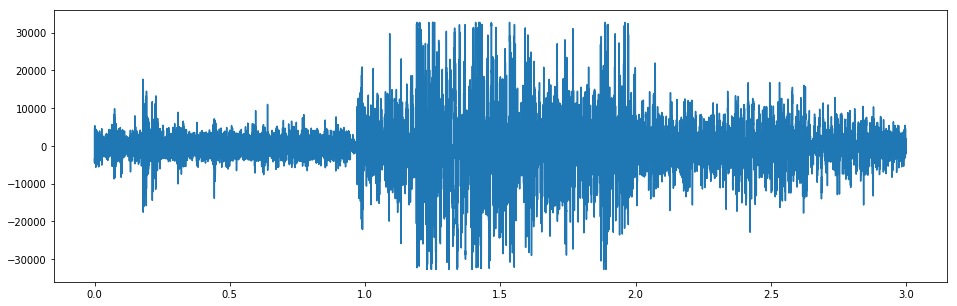

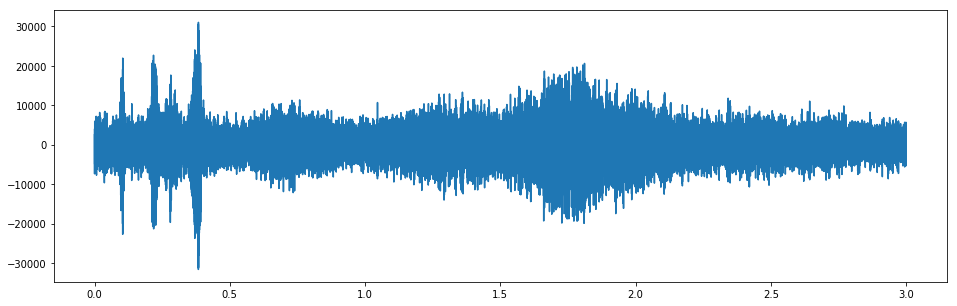

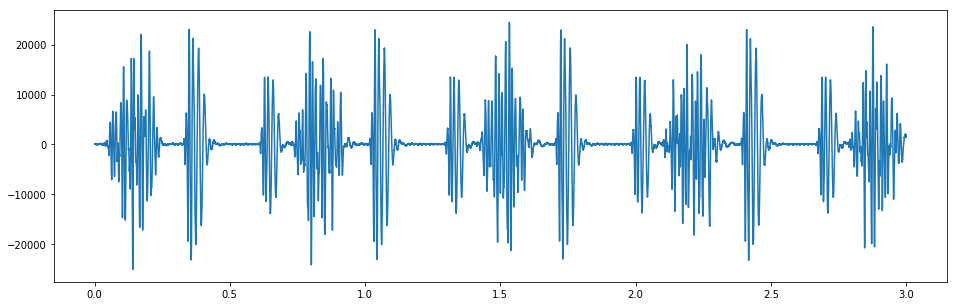

(154432,)


In [6]:
#"""Graficar archivo de sonido WAV"""
nsamp = Sounds[0].shape[0]
time  = np.linspace(0,nsamp/Fs[0],nsamp)

for s in Sounds:
    trash = plt.figure(figsize=(16,5))
    trash = plt.plot(time,s)

trash = plt.show()

print time.shape

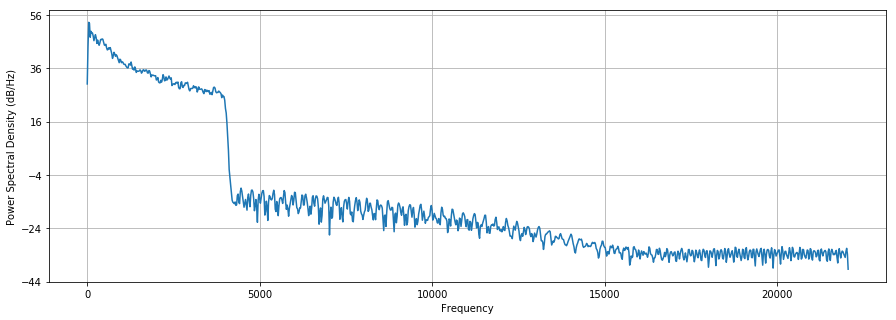

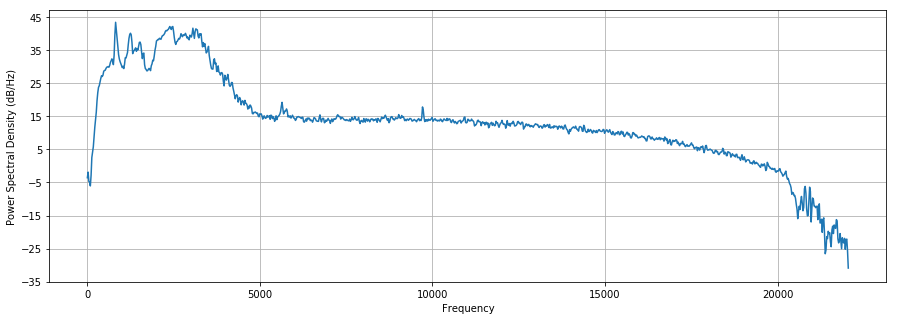

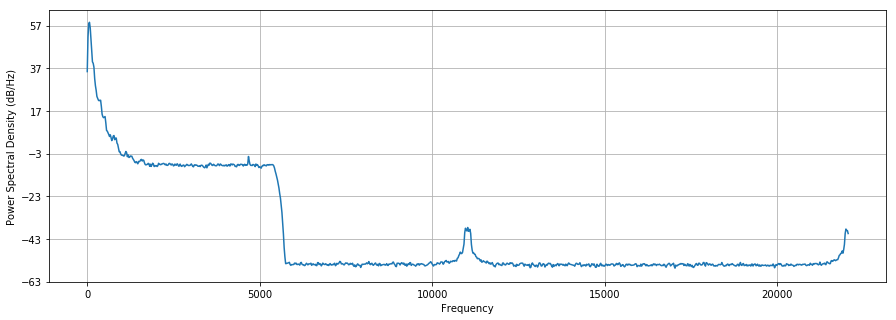

In [16]:
for s in Sounds:
    trash = plt.figure(figsize=(15,5))
    trash = plt.psd(s,2048,Fs=Fs[0])

trash = plt.show()

### 1.2. Mezclar sonidos
#### 1.2.1. Matriz de mezcla
$$\mathbf{A} = \left(
\begin{array}{ccc}
-.3 & .1 & .3 \\
.1 & .5 & -.2\\
.3 & .6 & -.6
\end{array} \right)$$

In [10]:
A = np.array([  [-.3 , .1 , .3], [.1 , .5 , -.2], [.2 , -.6 , -.6]  ])
print A, Sounds.shape

[[-0.3  0.1  0.3]
 [ 0.1  0.5 -0.2]
 [ 0.2 -0.6 -0.6]] (3, 154432)


#### 1.2.2. Mezclar los sonidos

In [11]:
Sounds_mix = np.dot( Sounds.T,A ).T

In [12]:
Sounds_mix = Sounds_mix.astype('int16')

### 1.3. Caracterización de sonidos mezclados

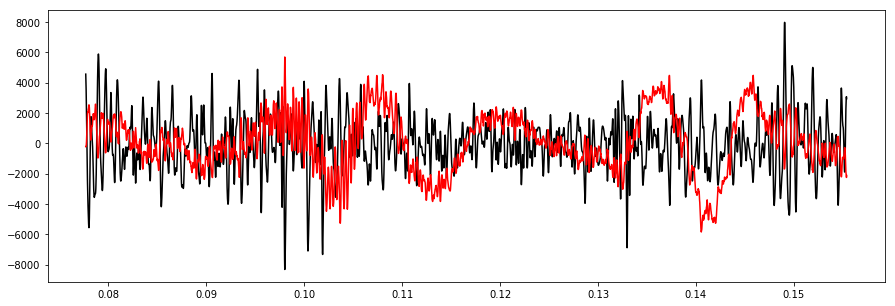

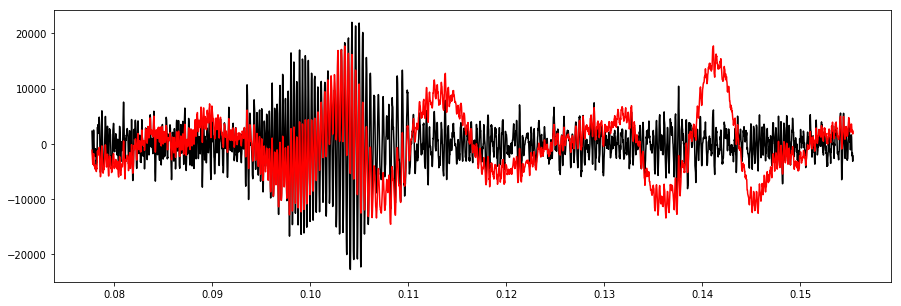

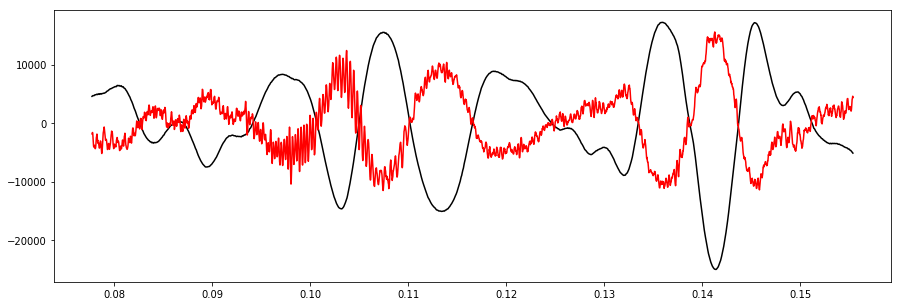

In [14]:
for s,sm in zip(Sounds,Sounds_mix):
    trash = plt.figure(figsize=(15,5))
    trash = plt.plot(time[4000:8000],s [4000:8000],'k')
    trash = plt.plot(time[4000:8000],sm[4000:8000],'r')

trash = plt.show()

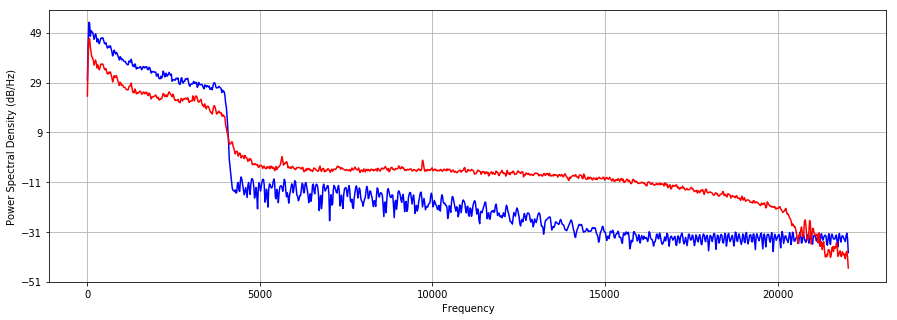

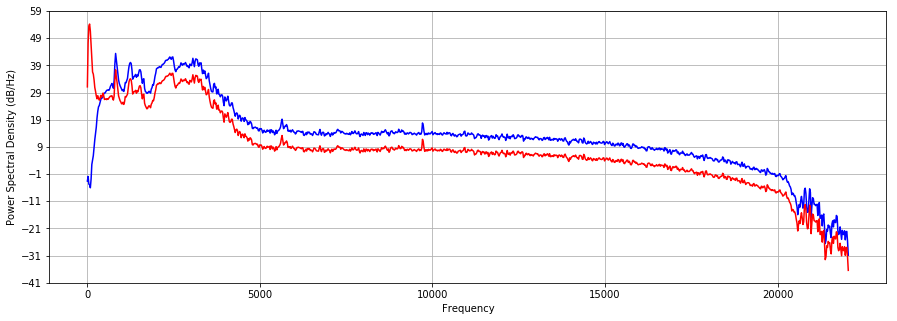

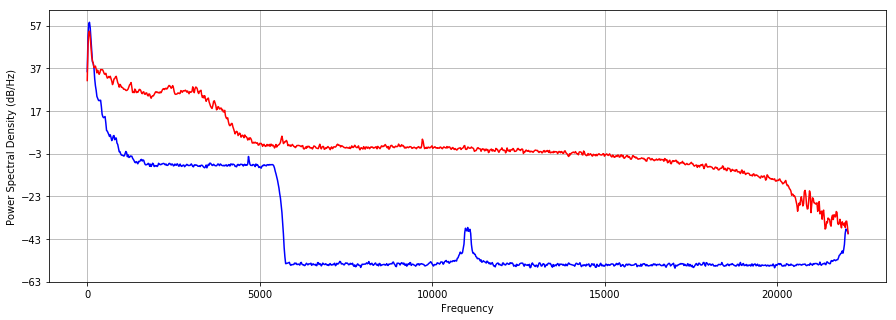

In [17]:
for s,sm in zip(Sounds,Sounds_mix):
    trash = plt.figure(figsize=(15,5))
    trash = plt.psd(s ,2048,Fs=Fs[0],color='b')
    trash = plt.psd(sm,2048,Fs=Fs[0],color='r')

trash = plt.show()


In [18]:
for s in Sounds_mix:
    sd.play(s,Fs[0],blocking=True)

## 1.3. Separación de fuentes.

En este caso, la matriz $A$ es conocida, por lo que la mezcla dada por 
$${\bf s = A x^T}$$,

puede revertirse utilizando $A^{-1}$
$${\bf \hat{x} = A^{-1} s^T}$$

In [19]:
from numpy import linalg as llg

A_inv = llg.inv(A)
print A_inv

[[-5.25  -1.5   -2.125]
 [ 0.25   1.5   -0.375]
 [-2.    -2.    -2.   ]]


In [21]:
Sounds_rec = np.dot( Sounds_mix.T,A_inv ).T

In [23]:
Sounds_rec = Sounds_rec.astype('int16')

### 1.3.1 Comparación entre fuentes originales y reconstruidas

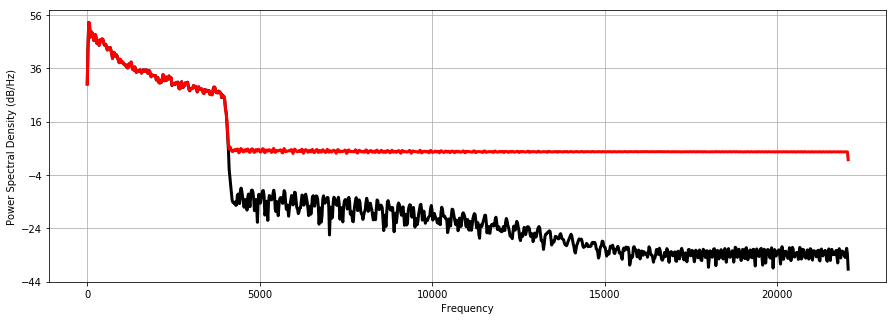

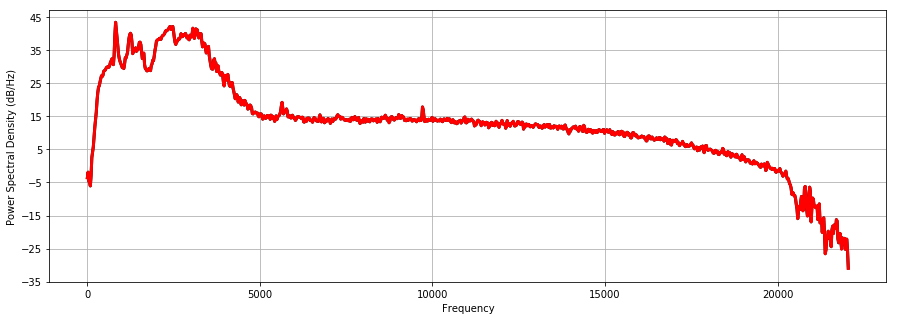

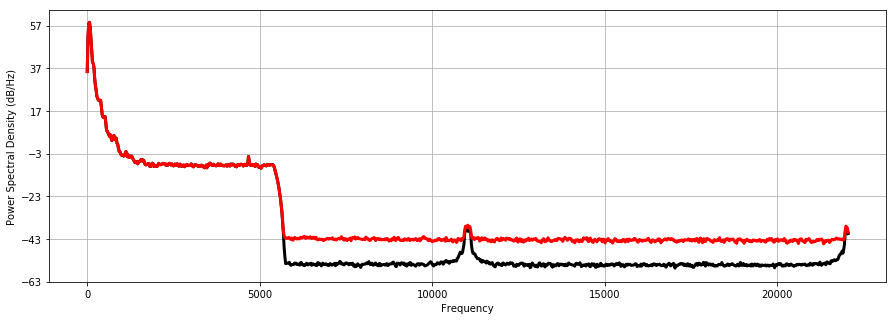

In [30]:
for s,sm,sr in zip(Sounds,Sounds_mix,Sounds_rec):
    trash = plt.figure(figsize=(15,5))
    #trash = plt.psd(sm,2048,Fs=Fs[0],color='b',linewidth=3)
    trash = plt.psd(s ,2048,Fs=Fs[0],color='k',linewidth=3)
    trash = plt.psd(sr,2048,Fs=Fs[0],color='r',linewidth=3)

trash = plt.show()

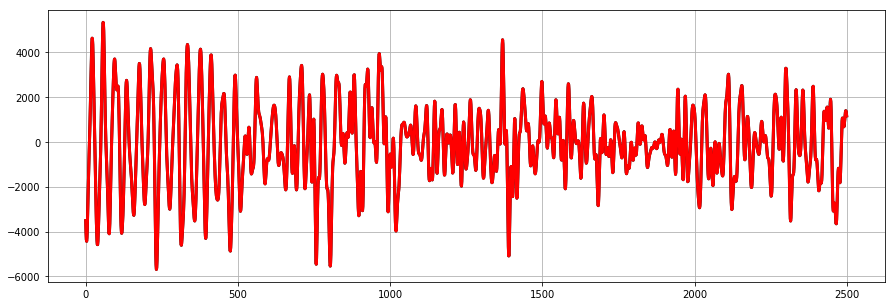

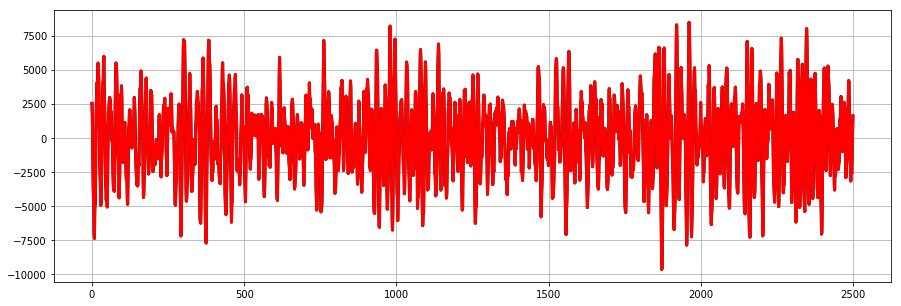

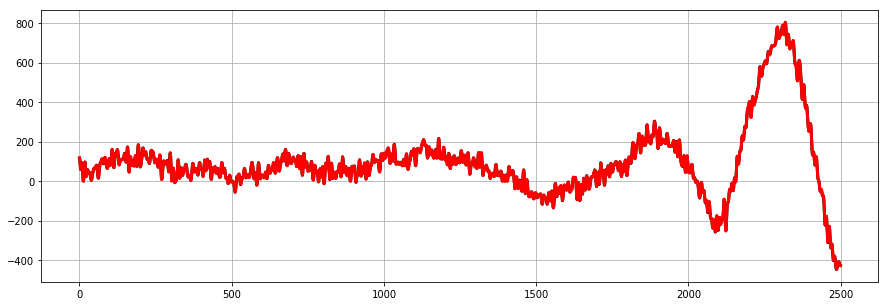

In [35]:
L = 2500
for s,sm,sr in zip(Sounds,Sounds_mix,Sounds_rec):
    trash = plt.figure(figsize=(15,5))
    #trash = plt.psd(sm,2048,Fs=Fs[0],color='b',linewidth=3)
    trash = plt.plot(s [:L] ,color='k',linewidth=3)
    trash = plt.plot(sr[:L] ,color='r',linewidth=3)
    trash = plt.grid(True)

trash = plt.show()

In [38]:
print Sounds.shape, Sounds_rec.shape

(3, 154432) (3, 154432)


In [43]:
print ( (Sounds - Sounds_rec)**2 ).astype('float').mean(axis=-1)

[6.97040769 1.69864406 1.63199984]


In [44]:
for s in Sounds_rec:
    sd.play(s,Fs[0],blocking=True)

# 2. Independent Component Analysis ICA

En la práctica, la matriz de mezcla $A$ es desconocida por lo que hay que estimarla.

Uno de los métodos más utilizados es [FastICA](https://www.cs.helsinki.fi/u/ahyvarin/papers/fastica.shtml)

In [60]:
#"""Importar clases"""
from sklearn.decomposition import FastICA as fica

#"""Crear una instancia de la clase y entrenar"""
model = fica(max_iter=1000)
model.fit(Sounds_mix.T)


FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=1000,
    n_components=None, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

${\bf A^{-1}}$

In [56]:
print model.components_

[[ 2.01784841e-06 -9.88858124e-08  7.77785908e-07]
 [ 9.15997405e-07 -9.37767185e-07  1.23811990e-06]
 [-7.92422224e-07 -1.42592454e-07 -7.76166451e-07]]


${\bf A}$

In [57]:
print model.mixing_

[[  771610.1527136   -160103.28806585   517827.63367322]
 [ -230479.95872709  -810379.14121745 -1523655.91574937]
 [ -745428.16139002   312334.23404295 -1537139.73076268]]


Obteniendo las fuentes

In [61]:
#"""Proyectar la matriz de re composición para obtener las fuentes"""
Sounds_fica = ( np.dot( model.components_,Sounds_mix )*500000 ).astype('int16')

In [62]:
"""Escuchar las fuentes aproximadas por FastICA"""
for s in Sounds_fica:
    sd.play(s,Fs[0],blocking=True)

ICA:
 - No escala
 - No signo
 - No orden

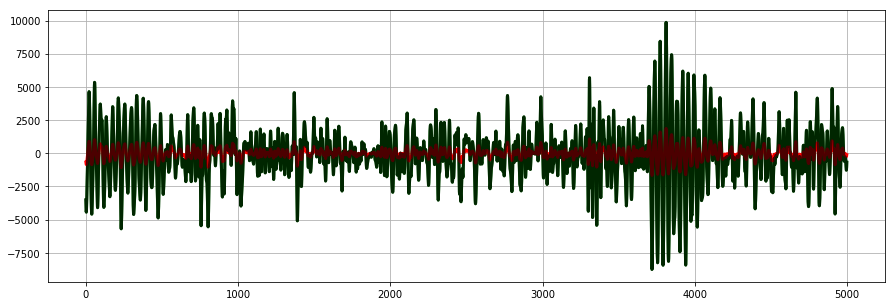

In [86]:
L = 5000
C = 1

trash = plt.figure(figsize=(15,5))
trash = plt.plot(  Sounds_rec [0,:L] ,color='g',linewidth=3)
trash = plt.plot(C*Sounds_fica[1,:L] ,color='r',linewidth=3)
trash = plt.plot(  Sounds     [0,:L] ,color='k',linewidth=3,alpha=.7)
trash = plt.grid(True)

trash = plt.show()

In [87]:
( (Sounds[0] - C*Sounds_fica[1])**2 ).astype('float').mean(axis=-1)

170.51741866970576

# 3. Aplicación ICA

In [88]:
import numpy             as np
import matplotlib.pyplot as plt
import sounddevice       as sd

from scipy import signal

#### Definición de parámetros

In [117]:
fs                    = 8400
duracion              = 5  #segundos
sd.default.samplerate = fs
sd.default.channels   = 2

#### Grabar sonido

In [120]:
#sd.wait()
sound = sd.rec( int(duracion * fs), dtype='float64', blocking=True)

#### Reproducir

In [121]:
sd.play(sound)

#### Graficar

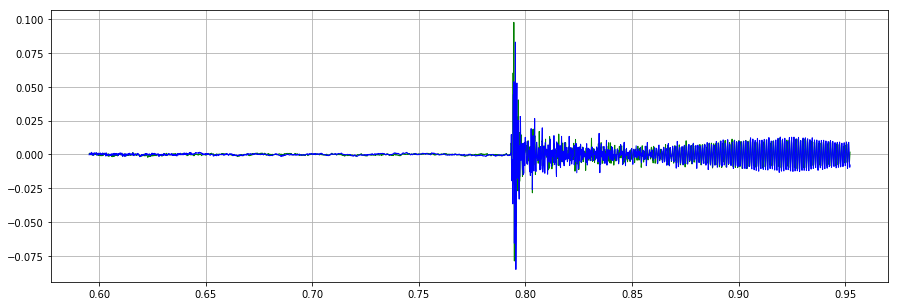

In [122]:
t  = np.linspace(0,duracion,int(duracion * fs) )
ts = [5000,8000]

plt.figure( figsize=(15,5) )
plt.plot(t[ ts[0]:ts[1] ],sound[ ts[0]:ts[1],0 ] ,'g',linewidth=1)
plt.plot(t[ ts[0]:ts[1] ],sound[ ts[0]:ts[1],1 ] ,'b',linewidth=1)
plt.grid(True)
plt.show()

In [123]:
#"""Importar clases"""
from sklearn.decomposition import FastICA as fica

#"""Crear una instancia de la clase y entrenar"""
model = fica(max_iter=1000)
model.fit(sound)


FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=1000,
    n_components=None, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

In [124]:
print model.components_

[[ 0.70185847 -0.40859987]
 [-0.21284196  0.60152729]]


In [125]:
#"""Proyectar la matriz de re composición para obtener las fuentes"""
sounds_fica = ( np.dot( model.components_,sound.T )*500000 ).astype('int16')

In [126]:
for s in sounds_fica:
    sd.play(s,fs,blocking=True)

In [165]:
#"""Importar clases"""
from sklearn.decomposition import KernelPCA as kpca

#"""Crear una instancia de la clase y entrenar"""
#model       = kpca(n_components=2,max_iter=1000,kernel='rbf')
#model.fit(sound[:4000])

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='rbf',
     kernel_params=None, max_iter=1000, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)

In [ ]:
#sounds_kpca = model.transform(sound)

In [162]:
for s in sounds_fica:
    sd.play(s,fs,blocking=True)

In [164]:
for s in sounds_kpca.T:
    sd.play(s,fs,blocking=True)